## Research Project 2
---
```text
- Source: SEC
- Goal: Extract information from HTML tables (DEF 14A)
- Techniques: HTML parsing, NER, DataFrames
- Tools: Beautifulsoup, pandas, spacy
- Lines of code: ~100```

### Get all tables from a webpage
---

In [1]:
import requests
from lxml import html

In [3]:
url = 'https://www.sec.gov/Archives/edgar/data/789019/000119312517310951/d461626ddef14a.htm'
res = requests.get(url)
tree = html.fromstring(res.content)

In [8]:
tables = tree.xpath('//table')
len(tables)

427

<div class="alert alert-block alert-info" 
     style="border-color: #2E86C1;
            background-color: #FCF3CF;
            border-left: 5px solid #2E86C1;
            padding-top: 5px">
    <font size="4">
    <a href="../deep_dives/html.ipynb" style="text-decoration: none"> 
    <h3 style="font-family: monospace">Deep-dive</h3>
    <p style="margin-left: 100px;
              margin-right: 100px;
              line-height: 1.7em;">Hyper Text Markup Language (HTML) and XPath</p></a></font>
</div>

### Convert HTML tables to DataFrames
---

In [16]:
from lxml import etree
from bs4 import BeautifulSoup, Tag

def parse(table):
    table_string = re.sub(r'<br/?>', '\n', 
                          str(etree.tostring(table)), 
                          flags=re.DOTALL)
    new_table = BeautifulSoup(table_string, 'html.parser')

    row_ind, col_ind, output = 0, 0, []
    for row in new_table.find_all('tr'):
        smallest_row_span = 1
        for cell in row.children:
            if cell.name in ('td', 'th'):
                span = cell.get('rowspan')
                row_span = int(span) if span else 1
                smallest_row_span = min(smallest_row_span, row_span)
                span = cell.get('colspan')
                col_span = int(span) if span else 1
                while True:
                    if row_ind >= len(output) or \
                            col_ind >= len(output[row_ind]) \
                            or output[row_ind][col_ind] is None:
                        break
                    col_ind += 1
                for ii in range(row_ind, row_ind + row_span):
                    for jj in range(col_ind, col_ind + col_span):
                        while ii >= len(output):
                            output.append([])
                        while jj >= len(output[ii]):
                            output[ii].append(None)
                        if output[ii][jj] is None:
                            output[ii][jj] = str(cell.get_text())
                col_ind += col_span
        row_ind += smallest_row_span
        col_ind = 0
        
    output = [[i.replace('\xa0', ' ').strip() for i in j] for j in output]
    output = [i for i in output if any(bool(j) for j in i)]
    output[0] = [' '.join(i.split()).strip() for i in output[0]]
    output[0] = [i.replace('\\n', ' ').strip() for i in output[0]]
    output[1:] = [[i.replace(r'\n', ', ').strip() for i in j] for j in output[1:]]
    output = [[i if i else None for i in j] for j in output]
    
    return output

In [18]:
parse(tables[0])

[['☐', None, 'Preliminary Proxy Statement'],
 ['☐,',
  None,
  'Confidential, for Use of the Commission Only (as permitted by Rule 14a-6(e)(2))'],
 ['☒', None, 'Definitive Proxy Statement'],
 ['☐,', None, 'Definitive Additional Materials'],
 ['☐,', None, 'Soliciting Material Pursuant to §240.14a-12']]

In [19]:
parsed = []
for table in tables:
    parsed.append(parse(table))

In [25]:
parsed[135]

[['Name',
  None,
  'Fees earned or paid in cash¹ ($)',
  'Fees earned or paid in cash¹ ($)',
  None,
  None,
  'Stock awards ($)',
  'Stock awards ($)',
  None,
  None,
  'Matching charitable gifts² ($)',
  'Matching charitable gifts² ($)',
  None,
  None,
  'Total ($)',
  'Total ($)',
  None],
 ['William H. Gates III³,',
  None,
  None,
  '0',
  None,
  None,
  None,
  '0',
  None,
  None,
  None,
  '0',
  None,
  None,
  None,
  '0',
  None],
 ['Reid G. Hoffman4',
  None,
  None,
  '20,483',
  None,
  None,
  None,
  '32,773',
  None,
  None,
  None,
  '0',
  None,
  None,
  None,
  '53,256',
  None],
 ['Teri L. List-Stoll5',
  None,
  None,
  '140,000',
  None,
  None,
  None,
  '200,000',
  None,
  None,
  None,
  '15,000',
  None,
  None,
  None,
  '355,000',
  None],
 ['G. Mason Morfit,',
  None,
  None,
  '140,000',
  None,
  None,
  None,
  '200,000',
  None,
  None,
  None,
  '0',
  None,
  None,
  None,
  '340,000',
  None],
 ['Charles H. Noski6',
  None,
  None,
  '170,000'

In [26]:
import pandas as pd
table = parsed[135]
pd.DataFrame(table[1:], columns=table[0])

,Name,None,Fees earned or paid in cash¹ ($),Fees earned or paid in cash¹ ($),None,None,Stock awards ($),Stock awards ($),None,None,Matching charitable gifts² ($),Matching charitable gifts² ($),None,None,Total ($),Total ($),None
0,"William H. Gates III³,",None,None,0,None,None,None,0,None,None,None,0,None,None,None,0,None
1,Reid G. Hoffman4,None,None,"20,483",None,None,None,"32,773",None,None,None,0,None,None,None,"53,256",None
2,Teri L. List-Stoll5,None,None,"140,000",None,None,None,"200,000",None,None,None,"15,000",None,None,None,"355,000",None
3,"G. Mason Morfit,",None,None,"140,000",None,None,None,"200,000",None,None,None,0,None,None,None,"340,000",None
4,Charles H. Noski6,None,None,"170,000",None,None,None,"200,000",None,None,None,0,None,None,None,"370,000",None
5,"Helmut Panke,",None,None,"155,000",None,None,None,"200,000",None,None,None,"5,000",None,None,None,"360,000",None
6,Sandra E. Peterson7,None,None,"125,000",None,None,None,"200,000",None,None,None,"15,000",None,None,None,"340,000",None
7,"Charles W. Scharf,",None,None,"125,000",None,None,None,"200,000",None,None,None,0,None,None,None,"325,000",None
8,"John W. Stanton,",None,None,"140,000",None,None,None,"200,000",None,None,None,0,None,None,None,"340,000",None
9,John W. Thompson8,None,None,"125,000",None,None,None,"550,000",None,None,None,"15,000",None,None,None,"690,000",None


In [55]:
df = pd.DataFrame(table[1:], columns=table[0])
df = df.dropna(axis=1, how='all')
df.columns = ['Name'] + df.columns.values.tolist()[1:]
df

,Name,Fees earned or paid in cash¹ ($),Stock awards ($),Matching charitable gifts² ($),Total ($)
0,"William H. Gates III³,",0,0,0,0
1,Reid G. Hoffman4,"20,483","32,773",0,"53,256"
2,Teri L. List-Stoll5,"140,000","200,000","15,000","355,000"
3,"G. Mason Morfit,","140,000","200,000",0,"340,000"
4,Charles H. Noski6,"170,000","200,000",0,"370,000"
5,"Helmut Panke,","155,000","200,000","5,000","360,000"
6,Sandra E. Peterson7,"125,000","200,000","15,000","340,000"
7,"Charles W. Scharf,","125,000","200,000",0,"325,000"
8,"John W. Stanton,","140,000","200,000",0,"340,000"
9,John W. Thompson8,"125,000","550,000","15,000","690,000"


### Named Entity Recognition on Executives
---

In [56]:
import spacy
NLP = spacy.load('en_core_web_sm')

In [57]:
NLP('William H. Gates III³,').ents

(William H. Gates,)

In [58]:
NLP('William H. Gates III³,').ents[0].label_

'PERSON'

In [59]:
names = []
for name in df['Name'].values:
    clean = re.sub(r'\d+', '', name)
    ents = [i.text for i in NLP(clean).ents if i.label_ == 'PERSON']
    if not ents: ents = [name]
    print('"%s"\t= "%s"' % (name, ents[0]))
    names.append(ents[0])
df['Name'] = pd.Series(names)

"William H. Gates III³,"	= "William H. Gates"
"Reid G. Hoffman4"	= "Reid G. Hoffman"
"Teri L. List-Stoll5"	= "Teri L. List-Stoll"
"G. Mason Morfit,"	= "G. Mason Morfit"
"Charles H. Noski6"	= "Charles H. Noski"
"Helmut Panke,"	= "Helmut Panke"
"Sandra E. Peterson7"	= "Sandra E. Peterson"
"Charles W. Scharf,"	= "Charles W. Scharf"
"John W. Stanton,"	= "John W. Stanton"
"John W. Thompson8"	= "John W. Thompson"
"Padmasree Warrior9"	= "Padmasree Warrior"


In [60]:
df['Stock awards ($)'] = df['Stock awards ($)'].apply(lambda x: int(x.replace(',', '')))

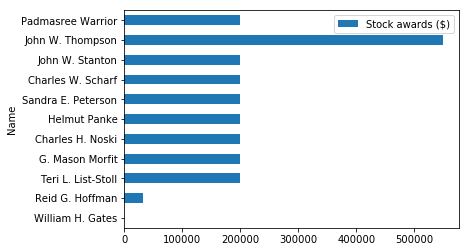

In [68]:
%matplotlib inline
ax = df.plot.barh(x='Name', y='Stock awards ($)')